## 1. Carga y exploración inicial del dataset

En esta sección se carga el conjunto de datos y se realiza una inspección preliminar de su estructura.  
El objetivo es comprender el tipo de variables, detectar valores nulos y obtener estadísticas descriptivas básicas que permitan tener una primera visión general del dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carga del conjunto de datos
df = pd.read_csv('../data/Student_Performance.csv')

# Exploración inicial de la estructura del dataset
print(df.info())
print(df.describe())

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  str    
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), str(1)
memory usage: 468.9 KB
None
       Hours Studied  Previous Scores   Sleep Hours  \
count   10000.000000     10000.000000  10000.000000   
mean        4.992900        69.445700      6.530600   
std         2.589309        17.343152      1.695863   
min         1.000000        40.000000      4.000000   
25%         3.000000        54.000000      5.000000   
50%  

## 2. Distribución de la variable objetivo (Performance Index)

En esta sección se analiza la distribución de la variable objetivo.  
El propósito es observar su forma (normalidad, asimetría, presencia de valores extremos) y comprender cómo se distribuyen los valores del rendimiento académico antes de proceder con el modelado.

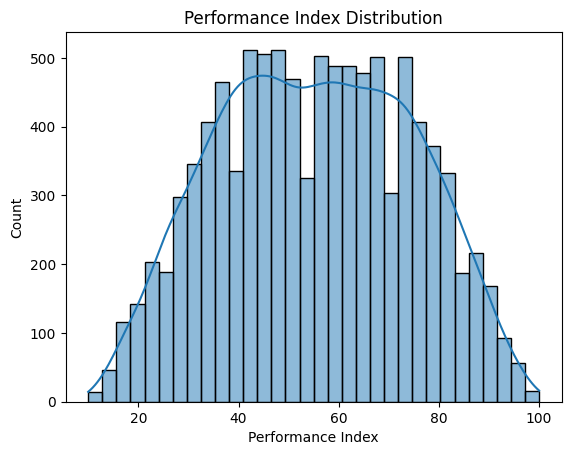

In [2]:
sns.histplot(df['Performance Index'], kde=True)
plt.title('Performance Index Distribution')
plt.show()

## 3. Análisis de correlaciones entre variables

En esta sección se convierte temporalmente la variable categórica en formato numérico para poder calcular la matriz de correlación.  
El objetivo es identificar qué variables presentan mayor relación con el Performance Index y detectar posibles relaciones fuertes entre predictores.

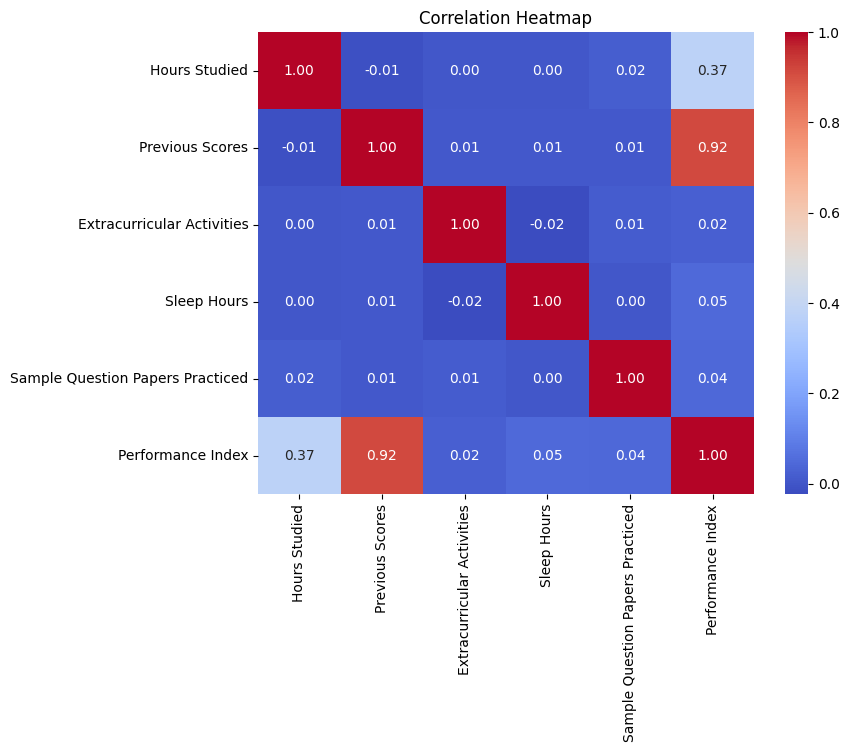

In [3]:
# Conversión temporal de la variable categórica (Yes/No) a valores numéricos
# para poder calcular la matriz de correlación
df_temp = df.copy()
df_temp['Extracurricular Activities'] = df_temp['Extracurricular Activities'].map({'Yes': 1, 'No': 0})

plt.figure(figsize=(8, 6))
sns.heatmap(df_temp.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

En el análisis exploratorio de datos (EDA), se observó que Previous Scores (0.92) y Hours Studied (0.37) son las variables más influyentes en el Performance Index.

Sin embargo, la influencia de Previous Scores es significativamente mayor, lo que podría provocar que el modelo dependa excesivamente de esta variable y tienda a ignorar el resto de los predictores.

Esta dependencia excesiva puede aumentar el riesgo de sobreajuste (overfitting), ya que el modelo podría capturar demasiado la estructura asociada a una sola variable.

Por esta razón, resulta necesario utilizar modelos de regularización como Ridge y Lasso, que permiten reducir la magnitud de los coeficientes y generar un modelo de predicción más equilibrado y robusto.

In [4]:
# Crear un nuevo DataFrame excluyendo la variable 'Previous Scores'
X = df.drop(['Performance Index', 'Previous Scores'], axis=1)
y = df['Performance Index']

# Conversión de la variable categórica Yes/No a valores numéricos (necesario para el modelo)
X['Extracurricular Activities'] = X['Extracurricular Activities'].map({'Yes': 1, 'No': 0})

## 4. Análisis de Regresión Lineal Simple (Hours Studied)

Antes de aplicar modelos con regularización, se realiza un modelo de regresión lineal simple utilizando únicamente la variable **Hours Studied**.

El objetivo es interpretar directamente la pendiente del modelo y analizar cuánto varía el rendimiento académico en función del tiempo dedicado al estudio.

In [ ]:
# 1. Análisis descriptivo básico de la variable
# Se observan medidas como media, desviación estándar, mínimo y máximo
print(df['Hours Studied'].describe())

# 2. Visualización mediante gráfico de dispersión con línea de regresión
# Se representa la relación entre las horas de estudio y el rendimiento académico
plt.figure(figsize=(8, 5))
sns.regplot(data=df, x='Hours Studied', y='Performance Index',
            scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.title('Relación Lineal: Hours Studied vs Performance')
plt.show()

# 3. Ajuste de un modelo de regresión lineal simple
# Se utiliza únicamente la variable "Hours Studied" como predictor
from sklearn.linear_model import LinearRegression

X_simple = df[['Hours Studied']]  # Selección de la variable independiente
y_simple = df['Performance Index']  # Variable objetivo

simple_model = LinearRegression()
simple_model.fit(X_simple, y_simple)

# 4. Interpretación del coeficiente (pendiente del modelo)
# La pendiente indica cuánto varía el rendimiento por cada hora adicional de estudio
pendiente = simple_model.coef_[0]
print(f"Pendiente (Slope): {pendiente:.4f}")

# 5. Evaluación del coeficiente de determinación (R²)
# Mide qué proporción de la variabilidad del rendimiento es explicada por el modelo
r2_simple = simple_model.score(X_simple, y_simple)
print(f"R² (Coeficiente de determinación): {r2_simple:.4f}")

## 5. División del dataset en entrenamiento, validación y prueba

En esta etapa se divide el conjunto de datos en tres partes:  
- 70% para entrenamiento del modelo  
- 15% para validación  
- 15% para prueba  

Esta separación permite entrenar el modelo, ajustar hiperparámetros y evaluar su capacidad de generalización sin generar sesgos.

In [5]:
from sklearn.model_selection import train_test_split

# Primero dividimos el dataset completo: 70% para entrenamiento (Train)
# y el 30% restante como conjunto temporal (temp).
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Luego dividimos el 30% restante en dos partes iguales:
# 15% para validación (Val) y 15% para prueba (Test).
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 7000, Val: 1500, Test: 1500


## 6. Entrenamiento del modelo Ridge

En esta sección se entrena un modelo de regresión Ridge utilizando el conjunto de entrenamiento (70%).  
El objetivo es evaluar su rendimiento inicial en el conjunto de validación y observar su capacidad de generalización.

In [6]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error

# Creación del modelo Ridge
ridge_model = Ridge(alpha=1.0)

# Entrenamiento del modelo utilizando el 70% de los datos (Train)
ridge_model.fit(X_train, y_train)

# Evaluación del modelo con el 15% de los datos de validación (Validation)
val_pred = ridge_model.predict(X_val)
print(f"Validation R2 Score: {r2_score(y_val, val_pred)}")

Validation R2 Score: 0.14303612680124422


## 7. Entrenamiento del modelo Lasso

En esta sección se entrena un modelo Lasso con el objetivo de comparar su rendimiento con el modelo Ridge.  
Lasso introduce regularización L1, lo que permite reducir algunos coeficientes exactamente a cero y realizar una selección automática de variables.  

Además de evaluar el R² en validación, se analizan los coeficientes para identificar qué variables permanecen en el modelo.

In [7]:
from sklearn.linear_model import Lasso

# Creación del modelo Lasso (alpha representa la intensidad de la regularización)
lasso_model = Lasso(alpha=1.0)

# Entrenamiento del modelo
lasso_model.fit(X_train, y_train)

# Evaluación en el conjunto de validación
lasso_val_pred = lasso_model.predict(X_val)
print(f"Lasso Validation R2 Score: {r2_score(y_val, lasso_val_pred)}")

# Verificación de qué variables permanecen en el modelo
# (Característica del Lasso: las variables menos relevantes se reducen a coeficiente 0)
coeff_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso_model.coef_})
print(coeff_df)

Lasso Validation R2 Score: 0.1399297943860931
                            Feature  Coefficient
0                     Hours Studied     2.651127
1        Extracurricular Activities     0.000000
2                       Sleep Hours     0.171073
3  Sample Question Papers Practiced     0.131030


## 8. Evaluación del sobreajuste (Overfitting)

En esta sección se compara el rendimiento del modelo en el conjunto de entrenamiento y en el conjunto de validación.  
El objetivo es comprobar si el modelo presenta sobreajuste, analizando la diferencia porcentual entre ambos resultados.

In [8]:
# 1. Predicción sobre el conjunto de entrenamiento
train_pred = ridge_model.predict(X_train)
train_r2 = r2_score(y_train, train_pred)

# 2. Predicción sobre el conjunto de validación (calculado previamente)
val_r2 = r2_score(y_val, val_pred)

print(f"Train R2: {train_r2:.4f}")
print(f"Validation R2: {val_r2:.4f}")

# 3. Cálculo de la diferencia porcentual entre entrenamiento y validación
diff = (train_r2 - val_r2) / train_r2 * 100
print(f"Diferencia: {diff:.2f}%")

if diff < 5:
    print("Menor al 5% (sin sobreajuste significativo)")
else:
    print("Posible sobreajuste (overfitting)")

Train R2: 0.1476
Validation R2: 0.1430
Diferencia: 3.10%
Menor al 5% (sin sobreajuste significativo)


El modelo Lasso determinó que la variable “Extracurricular Activities” no aporta información relevante para la predicción del rendimiento académico, reduciendo su coeficiente a cero.

Esto significa que, dentro del contexto de este modelo y este conjunto de datos, la participación en actividades extracurriculares no contribuye significativamente a mejorar la capacidad predictiva del modelo.

En consecuencia, si el objetivo es optimizar el Performance Index, parece más eficiente centrarse en otros factores con mayor peso predictivo que en la participación en actividades extracurriculares.

El coeficiente estimado para Hours Studied fue de 2.65.
Esto implica que, manteniendo constantes las demás variables (como las horas de sueño o el número de exámenes de práctica realizados), un incremento de una hora adicional de estudio se asocia, en promedio, con un aumento de 2.65 puntos en el Performance Index.

Desde el punto de vista cuantitativo, este resultado indica que, excluyendo la variable Previous Scores, las horas de estudio constituyen el factor con mayor impacto en el rendimiento académico, superando ampliamente a variables como Sleep Hours (0.17) o Sample Question Papers Practiced (0.13).

Por lo tanto, el análisis sugiere que el tiempo dedicado al estudio es un elemento clave en la predicción del desempeño académico dentro de este conjunto de datos.

## 9. Comparación entre valores reales y predichos

En esta sección se visualiza la relación entre los valores reales del Performance Index y las predicciones generadas por el modelo Lasso.  

El objetivo es evaluar visualmente la calidad del ajuste:  
si los puntos se aproximan a la línea diagonal, significa que el modelo predice con mayor precisión.

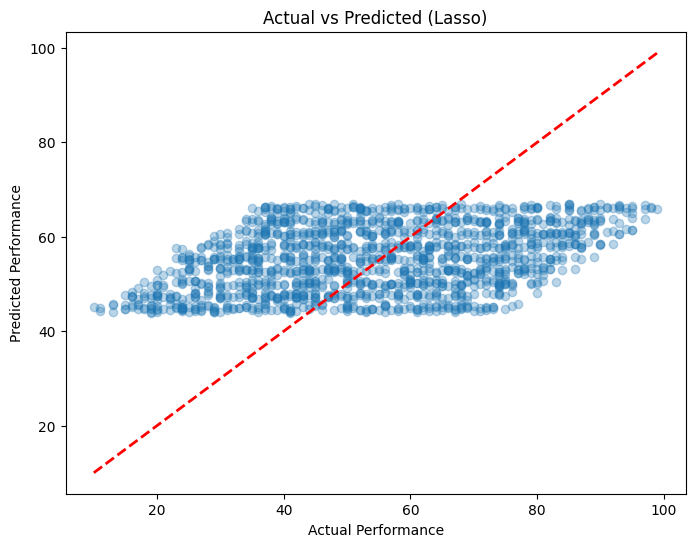

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, lasso_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Performance')
plt.ylabel('Predicted Performance')
plt.title('Actual vs Predicted (Lasso)')
plt.show()

## 10. Análisis de los residuos del modelo

En esta sección se analizan los residuos (diferencia entre los valores reales y los predichos).  

El objetivo es comprobar si los errores se distribuyen de manera aproximadamente normal y centrada en cero, lo cual indicaría que el modelo no presenta sesgos sistemáticos.

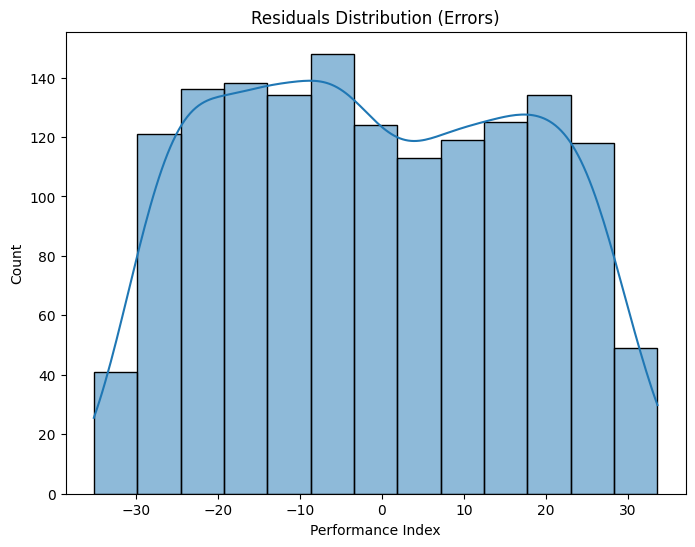

In [10]:
residuals = y_val - lasso_val_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution (Errors)')
plt.show()

## 11. Evaluación final en el conjunto de prueba

En esta etapa se evalúa el rendimiento final del modelo utilizando el conjunto de prueba (Test), el cual no fue utilizado durante el entrenamiento ni la validación.  

Esta evaluación permite medir la capacidad real de generalización del modelo y confirmar su rendimiento en datos no vistos previamente.

In [ ]:
final_test_pred = ridge_model.predict(X_test)
final_r2 = r2_score(y_test, final_test_pred)
final_mae = mean_absolute_error(y_test, final_test_pred)

print(f"Test R2: {final_r2:.4f}")
print(f"MAE: {final_mae:.2f} score")

Test R2: 0.1236
MAE: 15.58 score


## 12. Comparación alternativa con división 80/20

En esta sección se realiza una división alternativa del dataset (80% entrenamiento y 20% prueba) con el objetivo de comparar los resultados con la división anterior (70/15/15).  

Esta comparación permite analizar la estabilidad del modelo y verificar si el rendimiento se mantiene consistente bajo diferentes configuraciones de partición de datos.

In [12]:
# División 80/20 del dataset
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento del modelo Ridge con la división 80/20
ridge_80 = Ridge(alpha=1.0)
ridge_80.fit(X_train_80, y_train_80)

# Evaluación del rendimiento del modelo
train_r2_80 = ridge_80.score(X_train_80, y_train_80)
test_r2_20 = ridge_80.score(X_test_20, y_test_20)

print(f"[Resultados con división 80/20]")
print(f"Train R2: {train_r2_80:.4f}")
print(f"Test R2: {test_r2_20:.4f}")
print(f"Diferencia por posible sobreajuste: {abs(train_r2_80 - test_r2_20)*100:.2f}%")

[Resultados con división 80/20]
Train R2: 0.1451
Test R2: 0.1379
Diferencia por posible sobreajuste: 0.72%


## 13. Guardado del modelo entrenado

En esta sección se guarda el modelo entrenado en formato `.pkl` utilizando la librería `joblib`.  

Este paso permite reutilizar el modelo posteriormente sin necesidad de volver a entrenarlo, facilitando su integración en aplicaciones como APIs, dashboards o sistemas de producción.

In [13]:
import joblib
import os

# 1. Crear la carpeta donde se guardará el modelo si no existe.
save_path = '../src'
if not os.path.exists(save_path):
    os.makedirs(save_path)
    print(f"Carpeta creada correctamente: {save_path}")

# 2. Guardar el modelo entrenado (por ejemplo, ridge_model o lasso_model) como archivo.
# Aquí asumimos que guardamos ridge_model por haber mostrado un rendimiento más estable.
model_filename = os.path.join(save_path, 'ridge_student_performance_model.pkl')

# Convertir el objeto del modelo a un archivo .pkl utilizando joblib.dump
joblib.dump(ridge_model, model_filename)

print(f"✅ Modelo guardado correctamente en: {model_filename}")

✅ Modelo guardado correctamente en: ../src/ridge_student_performance_model.pkl
